In [1]:
library(performance)
library(ggplot2)
library(stats)
library(parallel)
library(dplyr)
library(readxl)
library(tidyverse)
library(rstatix)
library(ggpubr)
library(corrplot)

Warning message:
“package ‘performance’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘readxl’ was built under R version 4.3.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ─────

In [2]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

cor.mtest <- function(mat, conf.level = 0.95) {
  mat <- as.matrix(mat)
  n <- ncol(mat)
  p.mat <- matrix(NA, n, n)
  diag(p.mat) <- 0
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      tmp <- cor.test(mat[, i], mat[, j], method = "spearman", conf.level = conf.level)
      p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
    }
  }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}

In [3]:
meta_data <- read.csv("/home/workspace/private/bri_figure_all_files_test/jupyter//IHA_Review_Analysis/Other_Analysis/13_MSD_HAI_analysis/meta_data.csv")
meta_data_subset <- meta_data %>%
    filter(Visit_Type == "FluYear", Flu_Year %in% c("2020-2021", "2021-2022"), Flu_Day != "Stand-Alone") %>%
    group_by(subjectGuid, Flu_Year) %>%
    mutate(entry_count = n()) %>%
    filter(entry_count == 3) %>%
    ungroup()

# T cells

### Composite score

In [4]:
BRI_CompositeScore_Up<-read.csv("/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure1/04_CompositeScore/BRI_CompositeScore_Up.csv")


In [5]:
BRI_CompositeScore_Up<-BRI_CompositeScore_Up %>% select(pbmc_sample_id,composite_score_sum_scaled_mean,celltype)


In [6]:
colnames(BRI_CompositeScore_Up)[2]<-"BRI_CompositeScore_Up"


In [7]:
BRI_CompositeScore_Up <- pivot_wider(BRI_CompositeScore_Up, names_from =celltype, values_from = BRI_CompositeScore_Up)


In [8]:
colnames(BRI_CompositeScore_Up)[2:9]<-paste0("CompositeScore_Up_",colnames(BRI_CompositeScore_Up)[2:9])
BRI_CompositeScore_Up<-BRI_CompositeScore_Up %>% select(pbmc_sample_id,`CompositeScore_Up_CM CD4 T cell`,`CompositeScore_Up_CM CD8 T cell`,
                                                        `CompositeScore_Up_GZMK+ CD27+ EM CD8 T cell`,
                                                        `CompositeScore_Up_GZMB- CD27+ EM CD4 T cell`)

In [9]:
colnames(BRI_CompositeScore_Up)

[1] "pbmc_sample_id"                             
[2] "CompositeScore_Up_CM CD4 T cell"            
[3] "CompositeScore_Up_CM CD8 T cell"            
[4] "CompositeScore_Up_GZMK+ CD27+ EM CD8 T cell"
[5] "CompositeScore_Up_GZMB- CD27+ EM CD4 T cell"

In [10]:
BRI_CompositeScore_Up<-left_join(BRI_CompositeScore_Up,meta_data[c("pbmc_sample_id",'subject.subjectGuid',"sample.visitName")])

Joining with `by = join_by(pbmc_sample_id)`


In [11]:
BRI_CompositeScore_Up<-BRI_CompositeScore_Up %>% filter(sample.visitName=="Flu Year 1 Day 0")

### Phenotype  Score

In [12]:
df_cm_th2_score <- read.csv("/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/02_NMF_CD4_T_cell_Projection/Th2_Tfh_Baseline_Samples_BRI.csv")
df_cm_th2_score <- df_cm_th2_score %>%
    filter(NMF_Scores == "NMF5_Th2",  sample.visitName %in% c("Flu Year 1 Day 0"))
df_cm_th2_score <- df_cm_th2_score %>%
    select(AverageScore, pbmc_sample_id)
df_cm_th2_score_D0 <- left_join(df_cm_th2_score, meta_data) %>%
    select(AverageScore,  subjectGuid)
colnames(df_cm_th2_score_D0)[1]<- "CM CD4 T cell-Th2_Score-D0"

Joining with `by = join_by(pbmc_sample_id)`


In [13]:
df_cm_th2_score <- read.csv("/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/02_NMF_CD4_T_cell_Projection/Th2_Tfh_Baseline_Samples_BRI.csv")
df_cm_th2_score <- df_cm_th2_score %>%
    filter(NMF_Scores == "NMF6_Tfh",  sample.visitName %in% c("Flu Year 1 Day 0"))
df_cm_th2_score <- df_cm_th2_score %>%
    select(AverageScore, pbmc_sample_id)
df_cm_Tfh_score_D0 <- left_join(df_cm_th2_score, meta_data) %>%
    select(AverageScore, subjectGuid)
colnames(df_cm_Tfh_score_D0)[1]<- "CM CD4 T cell-Tfh_Score-D0"

Joining with `by = join_by(pbmc_sample_id)`


In [14]:
df_cm_th2_score <- read.csv("/home//workspace/IHA_Figure_Revision/Figure5/01_NMF_CD4_T_cell_Projection/Th2_Th1_Tfh_Baseline_Samples_BRI_GZMB-CD27+EMCD4Tcell.csv")
df_cm_th2_score <- df_cm_th2_score %>%
    filter(NMF_Scores == "NMF5_Th2",
           sample.visitName %in% c("Flu Year 1 Day 0"))
df_cm_th2_score <- df_cm_th2_score %>%
    select(AverageScore,
           pbmc_sample_id)
df_GZMK_Th2_score_D0 <- left_join(df_cm_th2_score,
                               meta_data) %>%
    select(AverageScore, subjectGuid)
colnames(df_GZMK_Th2_score_D0)[1]<- "GZMB- CD27+ EM CD4 T cell-Th2_Score-D0"

Joining with `by = join_by(pbmc_sample_id)`


# B cells

### HAI Response

In [15]:
df <- read.csv("/home/workspace/IHA_Figure_Revision/Figure4/03_Reponse_Grouping_HAI_MSD/lm_res.csv")

In [16]:
df<-df %>% filter(Assay=="Flu B/Phuket HA",Flu_Year=="2020-2021")

In [17]:
df_HAI_Response <- pivot_wider(df[c("subjectGuid", "residual", "Assay","Flu_Year")], names_from =c( "Assay","Flu_Year"), values_from = residual)
colnames(df_HAI_Response)[2:7] <- paste0("HAI_Response-", colnames(df_HAI_Response)[2:7])

### HAI Day 0

In [18]:
df_HAI <- read.csv("/home/workspace/IHA_Figure_Revision/Figure4/01_HAI_MSD_Assay/HAI_Processed.csv")
df_HAI <- df_HAI %>%
    group_by(Assay, Batch) %>%
    mutate(Adjusted_HAI.Mean_Perc_Inhib = Mean_Perc_Inhib - min(Mean_Perc_Inhib) * 1.00001)
df_HAI <- df_HAI %>%
    mutate(Assay = case_when(
        Assay == "A/Shanghai" ~ "Flu A/Shanghai H7", Assay == "A/Brisbane" ~ "Flu A/Brisbane (H1N1)", Assay == "B/Washington" ~ "Flu B/Washington HA",
        Assay == "B/Phuket" ~ "Flu B/Phuket HA", Assay == "A/HongKong" ~ "Flu A/Hong Kong H3", TRUE ~ Assay
    ))
df_HAI <- df_HAI[c(
    "sample.sampleKitGuid", "Assay", "Mean_Perc_Inhib", "Adjusted_HAI.Mean_Perc_Inhib", "cohort.cohortGuid", "subjectGuid", "CMV", "Flu_Year",
    "Flu_Day", "Visit_Type", "Year_N", "Visit_Flu_Year", "subject.biologicalSex"
)]
colnames(df_HAI)[1:3] <- c("sample.sampleKitGuid", "Assay", "HAI.Mean_Perc_Inhib")
df_HAI <- df_HAI %>%
    filter(Visit_Type == "FluYear", Flu_Day != "Stand-Alone") %>%
    dplyr::mutate(`Age Group` = case_when(cohort.cohortGuid == "BR1" ~ "Young", cohort.cohortGuid == "BR2" ~ "Older", TRUE ~ NA_character_)) %>%
    group_by(subjectGuid, Assay, Flu_Year) %>%
    arrange(Flu_Day) %>%
    dplyr::mutate(across(starts_with("Adjusted_HAI.Mean_Perc_Inhib"), ~ . - first(.), .names = "DeltaDiff_{col}")) %>%
    ungroup() %>%
    group_by(subjectGuid, Assay, Flu_Year) %>%
    arrange(Flu_Day) %>%
    mutate(Day0_Inhibition = first(Adjusted_HAI.Mean_Perc_Inhib)) %>%
    ungroup() %>%
    group_by(subjectGuid, Flu_Year, Assay) %>%
    mutate(entry_count = n()) %>%
    filter(entry_count == 3) %>%
    ungroup()

In [19]:
df_HAI_D0<-df_HAI %>% filter(Assay=="Flu B/Phuket HA",Flu_Day=="Day_0",Flu_Year=="2020-2021") %>% select(subjectGuid,Day0_Inhibition)

In [20]:
colnames(df_HAI_D0)[2]<- "HAI_D0_Phuket_2020-2021"

### Total IgG

In [21]:
df<-read.csv("/home//workspace/IHA_Figure_Revision/Figure4/02_Total_IgG_MSD_Assay/MSD_All.csv")

In [22]:
df_Total_IgG_D0<-df%>% filter(Assay=="Flu B/Phuket HA",Flu_Day=="Day_0",Flu_Year=="2020-2021")%>% select(subjectGuid,Calc..Conc..Mean)
colnames(df_Total_IgG_D0)[2]<- "Total_IgG_D0_Phuket_2020-2021"

In [23]:
df_Total_IgG_D7<-df%>% filter(Assay=="Flu B/Phuket HA",Flu_Day=="Day_7",Flu_Year=="2020-2021")%>% select(subjectGuid,Calc..Conc..Mean)
colnames(df_Total_IgG_D7)[2]<- "Total_IgG_D7_Phuket_2020-2021"

### Isotype divide by Total

In [24]:
df<-read.csv("/home//workspace/IHA_Figure_Revision/Figure4/10_Isotype_MSD/Isotype_Singal_IgG2_IgG3_Phuket.csv")

In [25]:
IgG2_to_Total_Ratio_D0<-df %>% filter(Isotype=="IgG2",Flu_Year=="2020-2021",Flu_Day=="Day_7") %>% select(subjectGuid,Isotype_to_Total_Singal_Ratio)
IgG3_to_Total_Ratio_D0<-df %>% filter(Isotype=="IgG3",Flu_Year=="2020-2021",Flu_Day=="Day_7")%>% select(subjectGuid,Isotype_to_Total_Singal_Ratio)

In [26]:
colnames(IgG2_to_Total_Ratio_D0)[2]<- "IgG2_to_Total_Ratio_D7_Phuket_2020-2021"
colnames(IgG3_to_Total_Ratio_D0)[2]<- "IgG3_to_Total_Ratio_D7_Phuket_2020-2021"

In [27]:
#IgG2_to_Total_Ratio_D0$`IgG2_to_Total_Ratio_D7_Phuket_2020-2021`<-log10(IgG2_to_Total_Ratio_D0$`IgG2_to_Total_Ratio_D7_Phuket_2020-2021`)
#IgG3_to_Total_Ratio_D0$`IgG3_to_Total_Ratio_D7_Phuket_2020-2021`<-log10(IgG3_to_Total_Ratio_D0$`IgG3_to_Total_Ratio_D7_Phuket_2020-2021`)


### Frequency from Flow validation

#### CD27 pos only

In [28]:
df<-readr::read_csv('/home//workspace/annotated1.csv')

Rows: 6937027 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): condition, donor, time, group, cell_type, L1, L2, L3, L4, Final_Ce...
dbl (22): FSC, FSC-H, SSC, SSC-B, SSC-B-H, SSC-H, CCR7, IFNg, CD3, CD45RA, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [29]:
freq_df <- df %>%
  group_by(donor, condition, Final_Celltype) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(donor, condition) %>%
  mutate(
    percentage = count / sum(count) * 100,
    percentage_clr = clr_transform(percentage)
  )

In [30]:
freq_df$cohort<-substr(freq_df$donor,1,3)
freq_df<-left_join(freq_df,unique(meta_data[c('subjectGuid','CMV')]),by =c("donor"="subjectGuid"))

In [31]:
freq_df$Group<-paste0(freq_df$condition,"-",freq_df$Final_Celltype)

In [32]:
freq_df_flow <- pivot_wider(freq_df[c("donor", "percentage", "Group")], names_from =c( "Group"), values_from = percentage)


In [33]:
freq_df_flow_subet_CD27pos_only<-freq_df_flow[grepl("donor|Unstimulated-IFNg\\- IL4\\+ CD27\\+ CM|TCR-IFNg\\+ IL4\\+ CD27\\+ CM",colnames(freq_df_flow))]

In [34]:
freq_df <- df %>%
  group_by(donor, condition, Final_Celltype) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(donor, condition) %>%
  mutate(
    percentage = count / sum(count) * 100,
    percentage_clr = clr_transform(percentage)
  )

In [35]:
freq_df$cohort<-substr(freq_df$donor,1,3)
freq_df<-left_join(freq_df,unique(meta_data[c('subjectGuid','CMV')]),by =c("donor"="subjectGuid"))

In [36]:
freq_df$Group<-paste0(freq_df$condition,"-",freq_df$Final_Celltype)

In [37]:
freq_df_flow <- pivot_wider(freq_df[c("donor", "percentage", "Group")], names_from =c( "Group"), values_from = percentage)


In [38]:
freq_df_flow_subet<-freq_df_flow[grepl("donor|Unstimulated-IFNg\\- IL4\\+ CD27\\+ CM|TCR-IFNg\\+ IL4\\+ CD27\\+ CM|Unstimulated-IFNg\\- IL4\\+ CD27\\+ EM|TCR-IFNg\\+ IL4\\+ CD27\\+ EM|Unstimulated-IFNg\\- IL4\\+ CD27\\- EM Memory CD4",colnames(freq_df_flow))]

### Supernant

In [39]:
df<-read.csv("/home//workspace/IHA_Figure_Revision/Figure5/03_Cytokine_TCR_Stim/Cytokine_Profile.csv")

In [40]:
df_IL4_4hrs<-df %>% filter(timepoint=="4 hrs", Cytokine=="IL4") %>% select(donor,Value)
df_IFNg_4hrs<-df %>% filter(timepoint=="4 hrs", Cytokine=="IFNy") %>% select(donor,Value)

In [41]:
colnames(df_IL4_4hrs)[2]<- "Cytokine_Profiling_IL4_4hr"
colnames(df_IFNg_4hrs)[2]<- "Cytokine_Profiling_IFNy_4hr"

# Combine them

In [42]:
colnames(freq_df_flow_subet)[1]<-"subjectGuid"
colnames(df_IL4_4hrs)[1]<-"subjectGuid"
colnames(df_IFNg_4hrs)[1]<-"subjectGuid"


In [43]:
df_combined<-left_join(df_cm_th2_score_D0,BRI_CompositeScore_Up %>% select(-pbmc_sample_id,-sample.visitName),by=c("subjectGuid"="subject.subjectGuid"))
df_combined<-left_join(df_combined,df_cm_Tfh_score_D0)
df_combined<-left_join(df_combined,df_GZMK_Th2_score_D0)

df_combined<-left_join(df_combined,df_HAI_Response)
df_combined<-left_join(df_combined,df_HAI_D0)


df_combined<-left_join(df_combined,df_Total_IgG_D0)
df_combined<-left_join(df_combined,df_Total_IgG_D7)

df_combined<-left_join(df_combined,IgG2_to_Total_Ratio_D0)
df_combined<-left_join(df_combined,IgG3_to_Total_Ratio_D0)

df_combined<-left_join(df_combined,freq_df_flow_subet)

df_combined<-left_join(df_combined,df_IL4_4hrs)
df_combined<-left_join(df_combined,df_IFNg_4hrs)

head(df_combined)

Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`
Joining with `by = join_by(subjectGuid)`


,CM CD4 T cell-Th2_Score-D0,subjectGuid,CompositeScore_Up_CM CD4 T cell,CompositeScore_Up_CM CD8 T cell,CompositeScore_Up_GZMK+ CD27+ EM CD8 T cell,CompositeScore_Up_GZMB- CD27+ EM CD4 T cell,CM CD4 T cell-Tfh_Score-D0,GZMB- CD27+ EM CD4 T cell-Th2_Score-D0,HAI_Response-Flu B/Phuket HA_2020-2021,HAI_D0_Phuket_2020-2021,⋯,TCR-IFNg+ IL4+ CD27+ CM Memory CD8+,TCR-IFNg+ IL4+ CD27+ EM Memory CD4+,TCR-IFNg+ IL4+ CD27+ EM Memory CD8+,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD8+,Unstimulated-IFNg- IL4+ CD27+ EM Memory CD4+,Unstimulated-IFNg- IL4+ CD27+ EM Memory CD8+,Unstimulated-IFNg- IL4+ CD27- EM Memory CD4+,Cytokine_Profiling_IL4_4hr,Cytokine_Profiling_IFNy_4hr
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.02702291,BR1001,-102.32731,-80.26792,-29.44935,-28.23380,0.1554709,0.016944902,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,0.02641466,BR1002,-112.55425,-74.70642,-46.24035,-34.28442,0.1261651,0.017482304,0.3797680,18.30585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,0.02087501,BR1003,-100.97091,-95.90450,-37.73503,-25.34190,0.1517972,0.009737843,1.0447882,54.32444,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,0.01579497,BR1004,-44.06742,-45.61995,-19.86044,-20.43016,0.1490361,0.008607486,-0.4286451,57.93029,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,0.03070205,BR1005,-25.30839,-33.14346,-16.51627,-20.86651,0.1714269,0.016395082,-0.1872958,65.70604,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,0.01994635,BR1006,-41.56218,-31.34764,-21.09361,-17.96050,0.1279383,0.007309073,-0.3262648,30.32818,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [44]:
df_combined <- df_combined[, c(2, 1, 3:ncol(df_combined))]
df_input<-df_combined

In [45]:
# Step 2: Calculate the p-value matrix
p_matrix <- cor.mtest(df_input[2:dim(df_input)[2]])


log10_p_matrix <- -log10(p_matrix)
log10_p_matrix[is.na(log10_p_matrix) | log10_p_matrix == Inf] <- 0  # Handle -Inf properly
upper_tri <- p_matrix[upper.tri(p_matrix, diag = T)]


transform_p <- function(x) {
    y <- 0.91 - (0.82) * (1 - exp(-3.82 * x))
    y
}

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"size_vector" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"size_vector" is not a graphical parameter”
Warning message in title(title, ...):
“"size_vector" is not a graphical parameter”


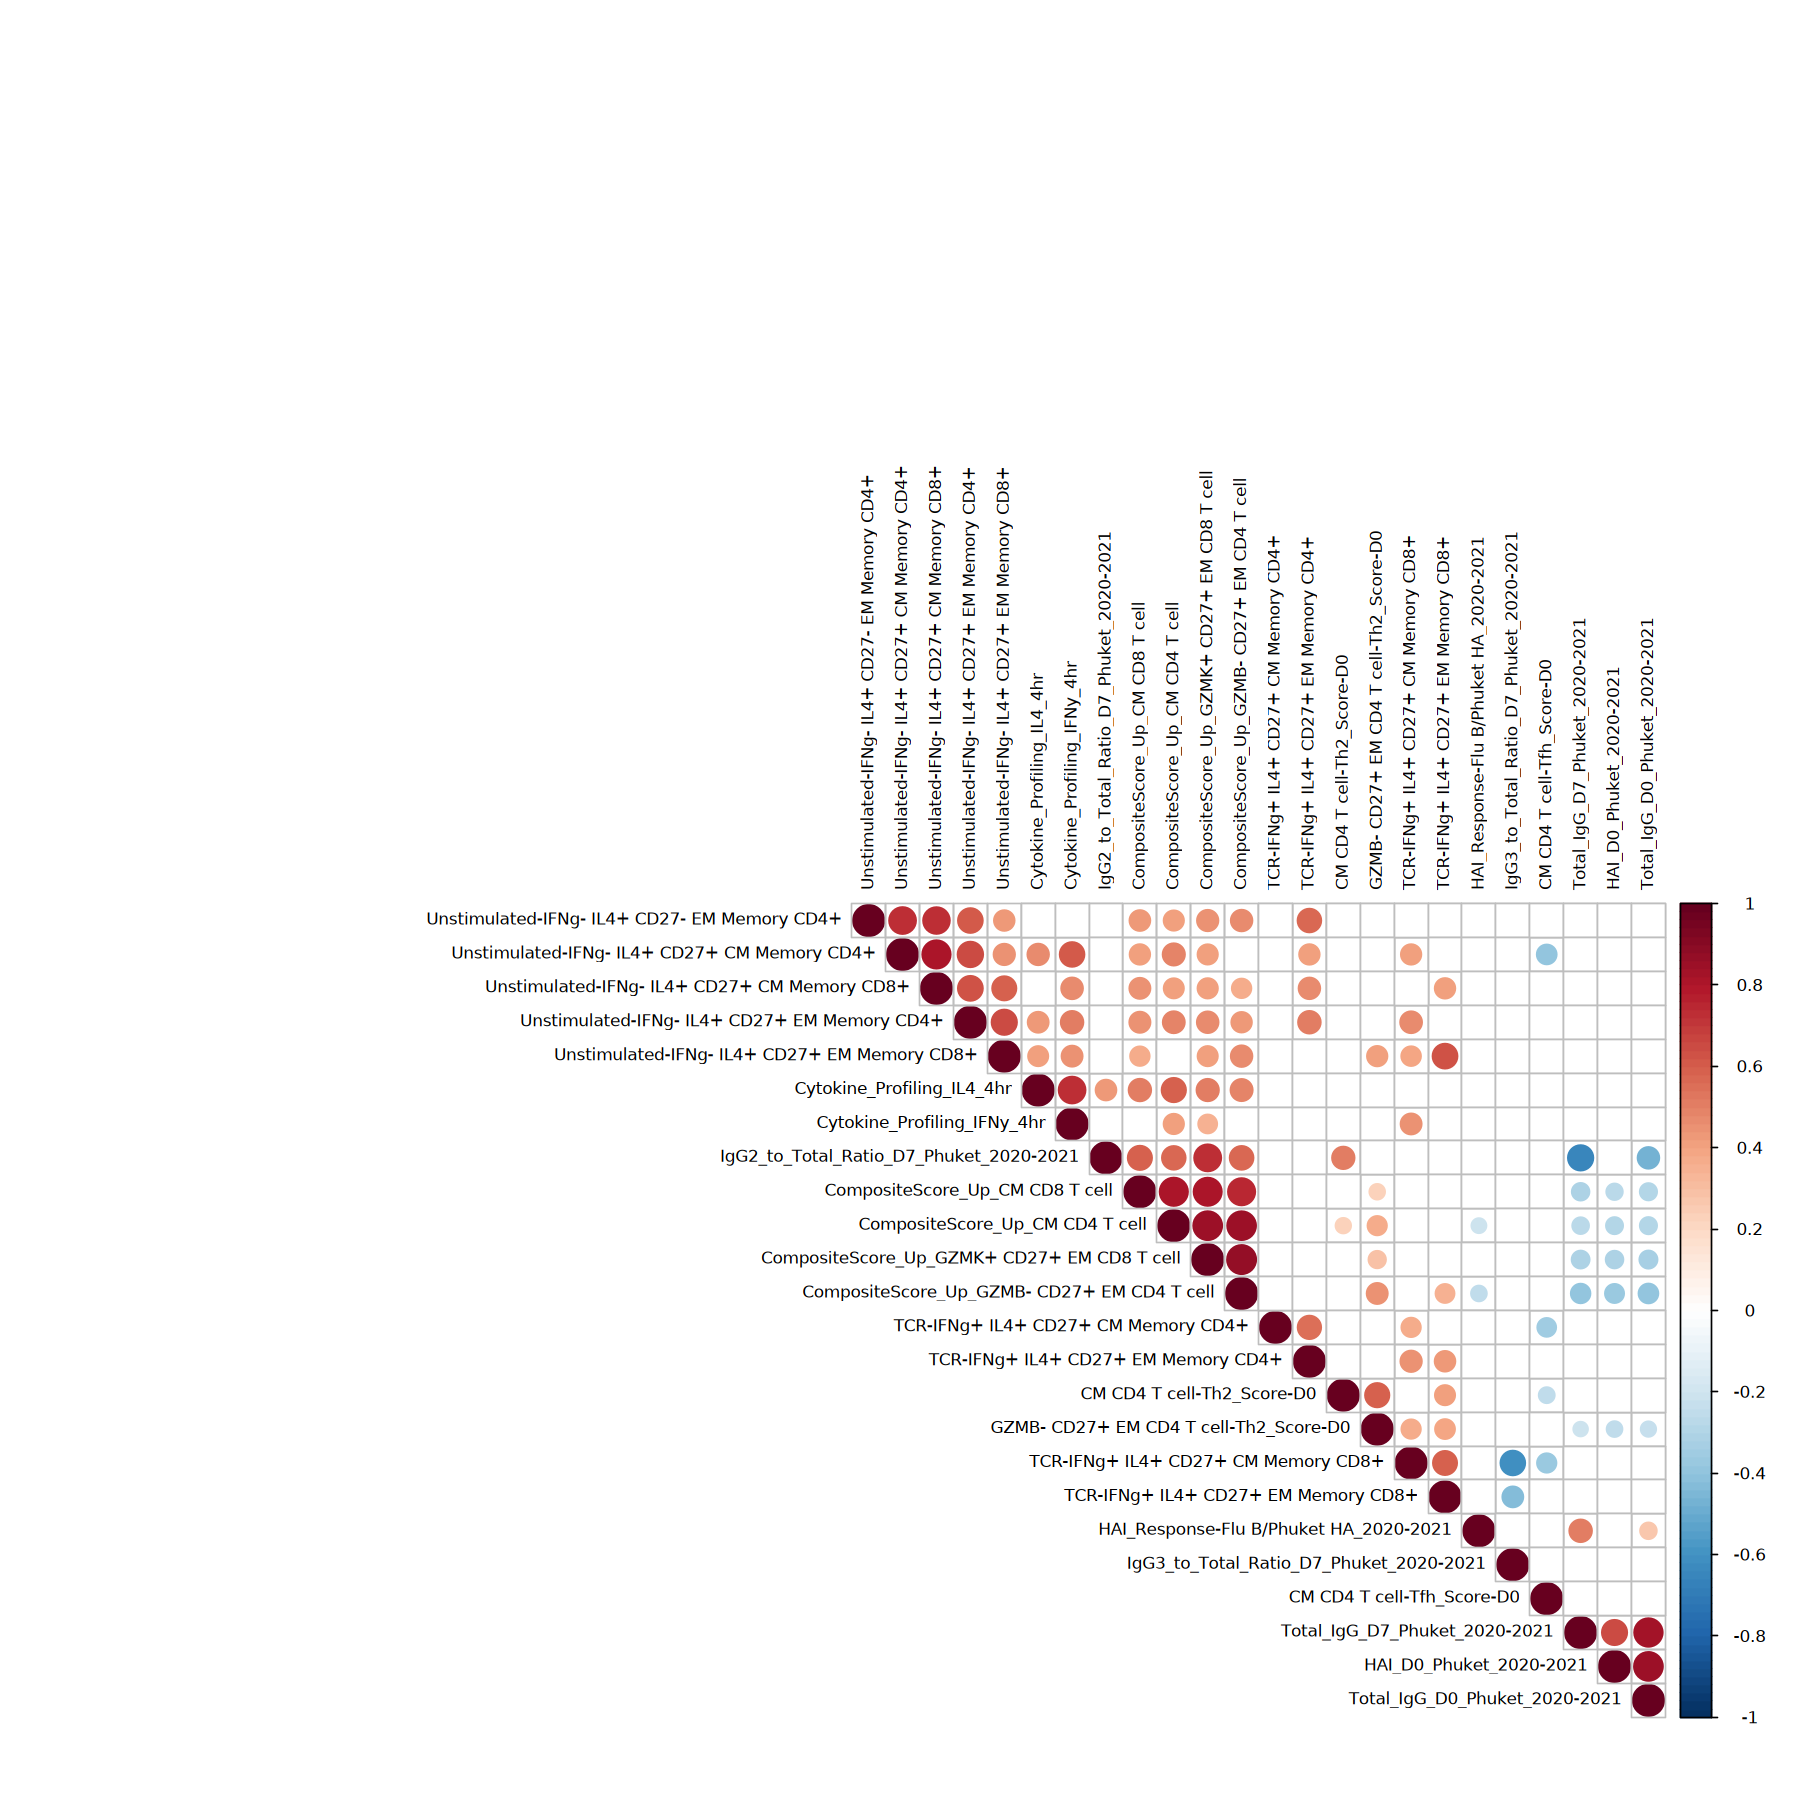

In [47]:
options(repr.plot.width = 15, repr.plot.height = 15)

corrplot(cor(df_input[2:dim(df_input)[2]], 
             method = "spearman",
             use = "pairwise.complete.obs"),  
         p.mat = p_matrix,    
         order="hclust",             
         sig.level = 0.05,  
         tl.col="black",
         insig = "blank",
         col=colorRampPalette(rev(c('#67001F', '#B2182B', 
                                    '#D6604D', '#F4A582', 
                                    '#FDDBC7', '#FFFFFF',
                                    '#D1E5F0', '#92C5DE', 
                                    '#4393C3', '#2166AC', 
                                    '#053061')))(100), 
         size_vector = transform_p(upper_tri), type = "upper", 
         tl.cex=0.8)  

In [48]:
df_subet<-df_input %>% select(subjectGuid,`Cytokine_Profiling_IL4_4hr`,`IgG2_to_Total_Ratio_D7_Phuket_2020-2021`,`Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+`)

In [49]:
long_df <- df_subet %>%
  pivot_longer(cols = 3:4, names_to = "variable", values_to = "value") %>% as.data.frame()
head(long_df)

,subjectGuid,Cytokine_Profiling_IL4_4hr,variable,value
,<chr>,<dbl>,<chr>,<dbl>
1,BR1001,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
2,BR1001,NA,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
3,BR1002,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
4,BR1002,NA,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
5,BR1003,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
6,BR1003,NA,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA


In [50]:
write.csv(long_df,"selected_pairs_set1.csv")

In [51]:
df_subet<-df_input %>% select(subjectGuid,`CompositeScore_Up_CM CD4 T cell`,`Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+`)

In [52]:
long_df <- df_subet %>%
  pivot_longer(cols = 3:3, names_to = "variable", values_to = "value") %>% as.data.frame()
head(long_df)

,subjectGuid,CompositeScore_Up_CM CD4 T cell,variable,value
,<chr>,<dbl>,<chr>,<dbl>
1,BR1001,-102.32731,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
2,BR1002,-112.55425,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
3,BR1003,-100.97091,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
4,BR1004,-44.06742,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
5,BR1005,-25.30839,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA
6,BR1006,-41.56218,Unstimulated-IFNg- IL4+ CD27+ CM Memory CD4+,NA


In [53]:
write.csv(long_df,"selected_pairs_set2.csv")

In [58]:
df_subet<-df_input %>% select(subjectGuid,`TCR-IFNg+ IL4+ CD27+ CM Memory CD8+`,
                              `IgG2_to_Total_Ratio_D7_Phuket_2020-2021`,
                              `IgG3_to_Total_Ratio_D7_Phuket_2020-2021`)

In [59]:
long_df <- df_subet %>%
  pivot_longer(cols = 3:4, names_to = "variable", values_to = "value") %>% as.data.frame()
head(long_df)

,subjectGuid,TCR-IFNg+ IL4+ CD27+ CM Memory CD8+,variable,value
,<chr>,<dbl>,<chr>,<dbl>
1,BR1001,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
2,BR1001,NA,IgG3_to_Total_Ratio_D7_Phuket_2020-2021,NA
3,BR1002,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
4,BR1002,NA,IgG3_to_Total_Ratio_D7_Phuket_2020-2021,NA
5,BR1003,NA,IgG2_to_Total_Ratio_D7_Phuket_2020-2021,NA
6,BR1003,NA,IgG3_to_Total_Ratio_D7_Phuket_2020-2021,NA


In [60]:
write.csv(long_df,"selected_pairs_set3.csv")